<!--
authors: Matthew Wilson, Daniele Reda
created: 2020/01/14
last_updated: 2023/02/08
-->


## CPSC 533V Project Part1 - Tabular Genetic Algorithm

In [ ]:
# # uncomment if necesary
!pip install numpy
# !pip install gym
# # OR:
!pip install gymnasium
!pip install gymnasium[classic-control]
import time
import itertools
import numpy as np
# import gym
import gymnasium as gym

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 9.3 MB/s eta 0:00:00


## Adapted from Assignemt 1

In [ ]:
env = gym.make('CartPole-v1', render_mode="human")  # you can also try LunarLander-v2, but make sure to change it back
print('observation space:', env.observation_space)
print('action space:', env.action_space)

# To find out what the observations mean, read the CartPole documentation.
# Uncomment the lines below, or visit the source file:
# https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py

cartpole = env.unwrapped
cartpole?

observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
action space: Discrete(2)


---

##  [12 pts] Discretize the env

Next, we need to discretize CartPole's continuous state space to work for tabular Q-learning.  While this is in part  a contrived usage of tabular methods, given the existence of other approaches that are designed to cope with continuous state-spaces, it is also interesting to consider whether tabular methods can be adapted more directly via discretization of the state into bins. Furthermore, tabular methods are simple, interpretabile, and can be proved to converge, and thus they still remain relevant.

Your task is to discretize the state/observation space so that it is compatible with tabular Q-learning.  To do this:
- **implement `obs_normalizer` to pass its test**
- **implement `get_bins` to pass its test**
- **then answer question 2.3**

[map]: https://arxiv.org/abs/1504.04909
[qd]: https://quality-diversity.github.io/

In [ ]:
env = gym.make('CartPole-v1')


In [ ]:
# 2.1 [5 pts for passing test_normed]
def obs_normalizer(obs):
    """Normalize the observations between 0 and 1

    If the observation has extremely large bounds, then clip to a reasonable range before normalizing;
    (-2,2) should work.  (It is ok if the solution is specific to CartPole)

    Args:
        obs (np.ndarray): shape (4,) containing an observation from CartPole using the bound of the env
    Returns:
        normed (np.ndarray): shape (4,) where all elements are roughly uniformly mapped to the range [0, 1]

    """
    # HINT: check out env.observation_space.high, env.observation_space.low

    # TODO: implement this function
    normed = np.ndarray(shape=(4,))
    for i in range(0, 2):
        normed[i] = max(-2, min(2, obs[i]))
        normed[i] = (normed[i] + 2) / 4

    normed[2] = (obs[2] + 4.1887903e-01) / (2 * 4.2e-01)

    # we'll take hitting the angle limit in 0.5 seconds as the angular velocity limit
    normed[3] = max(-2*4.1887903e-01, min(2*4.1887903e-01, obs[i]))
    normed[3] = (normed[3] + (2 * 4.1887903e-01)) / (4 * 4.2e-01)

    return normed

In [ ]:
### TEST 2.1
def test_normed():
    obs, info = env.reset()
    while True:
        obs, _, terminated, truncated, _ =  env.step(env.action_space.sample())
        normed = obs_normalizer(obs)
        assert np.all(normed >= 0.0) and np.all(normed <= 1.0), '{} are outside of (0,1)'.format(normed)
        if terminated | truncated: break
    env.close()
    print('Passed!')
test_normed()

Passed!


In [ ]:
# 2.2 [5 pts for passing test_binned]
def get_bins(normed, num_bins):
    """Map normalized observations (0,1) to bin index values (0,num_bins-1)

    Args:
        normed (np.ndarray): shape (4,) output from obs_normalizer
        num_bins (int): how many bins to use
    Returns:
        binned (np.ndarray of type np.int32): shape (4,) where all elements are values in range [0,num_bins-1]

    """
    # TODO: implement this function
    binned = np.ndarray(shape=(4,), dtype=np.int32)
    for i in range(0, 4):
        binned[i] = min(round(normed[i] * num_bins), num_bins-1)
    return binned

In [ ]:
### TEST 2.2
obs, info = env.reset()

def test_binned(num_bins):
    normed = np.array([0.0, 0.2, 0.8, 1.0])
    binned = get_bins(normed, num_bins)
    assert np.all(binned >= 0) and np.all(binned < num_bins), '{} supposed to be between (0, {})'.format(binned, num_bins-1)
    assert binned.dtype == np.int32, "You should also make sure to cast your answer to int using arr.astype(np.int32)"
test_binned(5)
test_binned(10)
test_binned(50)
print('Passed!')

Passed!


---

## [20 pts] Solve the env

Using the pseudocode below and the functions you implemented above, implement tabular Q-learning and use it to solve CartPole.

We provide setup code to initialize the Q-table and give examples of interfacing with it. Write the inner and outer loops to train your algorithm.  These training loops will be similar to those deep RL approaches, so get used to writing them!

The algorithm (excerpted from Section 6.5 of [Sutton's book](http://incompleteideas.net/book/RLbook2018.pdf)) is given below:

![Sutton RL](https://i.imgur.com/mdcWVRL.png)

in summary:
- **implement Q-learning using this pseudocode and the helper code**
- **answer the questions below**
- **run the suggested experiments and otherwise experiment with whatever interests you**

In [ ]:
env = gym.make('CartPole-v1')

# setup (see last few lines for how to use the Q-table)

# hyper parameters. feel free to change these as desired and experiment with different values
num_bins = 10
alpha = 0.1
gamma = 0.99
log_n = 1000
# epsilon greedy
eps = 0.05  #usage: action = optimal if np.random.rand() > eps else random

obs, info = env.reset()

# Q-table initialized to zeros.  first 4 dims are state, last dim is for action (0,1) for left,right.
# Q = np.zeros([num_bins]*len(obs)+[env.action_space.n])
Q = np.random.random(size=([num_bins]*len(obs)+[env.action_space.n])) * 20

# helper function to convert observation into a binned state so we can index into our Q-table
obs2bin = lambda obs: tuple(get_bins(obs_normalizer(obs), num_bins=num_bins))

s = obs2bin(obs)

print('Shape of Q Table: ', Q.shape) # you can imagine why tabular learning does not scale very well
print('Original obs {} --> binned {}'.format(obs, s))
print('Value of Q Table at that obs/state value', Q[s])

# print(Q)

Shape of Q Table:  (10, 10, 10, 10, 2)
Original obs [ 0.00800206 -0.02768429 -0.04370323 -0.04997461] --> binned (5, 5, 4, 5)
Value of Q Table at that obs/state value [17.47242934 11.35843114]


Algorithm for genetic algorithm:

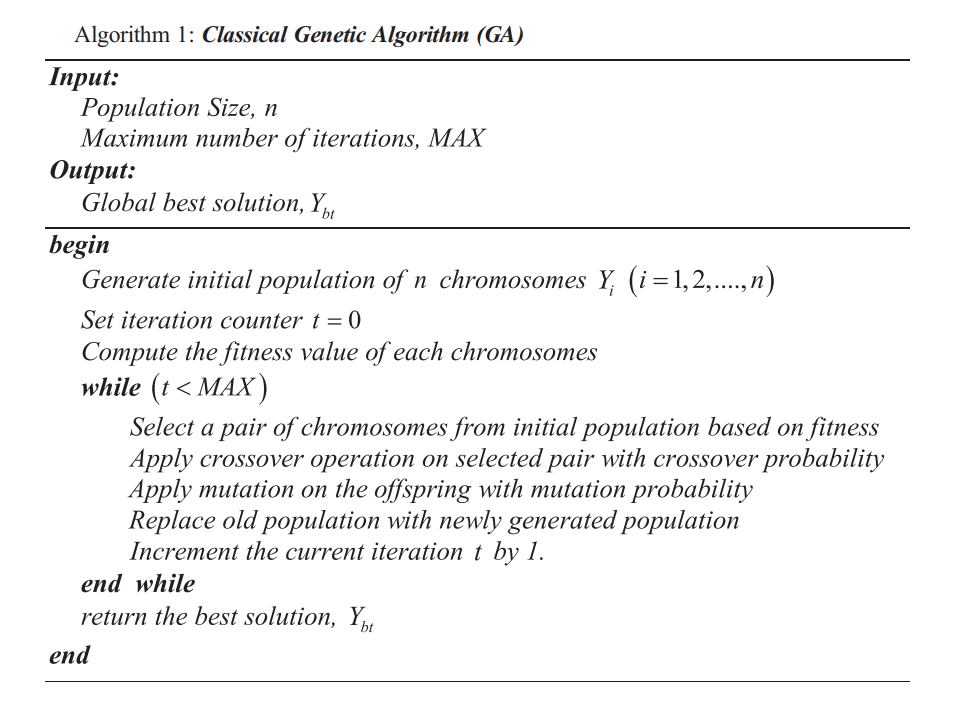

In [ ]:
env = gym.make('CartPole-v1')

# setup (see last few lines for how to use the Q-table)

# hyper parameters. feel free to change these as desired and experiment with different values
num_bins = 10
alpha = 0.1
gamma = 0.99
log_n = 1000

# genetic algo hyperparameters:
population_size = 200
max_generations = 100
max_iter_per_generation = 200
mutation_rate = 0.002
mutation_epsilon = 1
n_elites = 4
random_init_range = 20

obs, info = env.reset()


In [ ]:
# initialize population

# Q-table initialized to random 0 to random_init_range.  first 4 dims are state, last dim is for action (0,1) for left,right.
population = []
for i in range(population_size):
    # TODO initialize population
    population.append(np.random.randint(0, random_init_range, size=([num_bins]*len(obs)+[env.action_space.n])))
    # terminal states are zero
    for p in population:
        for v in range(num_bins):
            for w in range(num_bins):
              for a in range(2):
                for x in range(num_bins):
                    p[x][v][0][w][a] = 0
                    p[x][v][num_bins-1][w][a] = 0
                for t in range(num_bins):
                    p[0][v][t][w][a] = 0
                    p[num_bins - 1][v][t][w][a] = 0

In [ ]:
def uniform_crossover(parent1, parent2):
  offspring = parent1
  # randomly select a cell for half the total cells to replace
  for v in range(num_bins):
      for w in range(num_bins):
          for t in range(1, num_bins - 1):
              for x in range(1, num_bins - 1):
                for a in range(2):
                  if np.random.rand() < 0.5:
                    r = parent2[x][v][t][w][a]
  return offspring

def ranked_selection(population, rewards, population_size):
  left_parents = []
  right_parents = []
  rank = np.argsort(rewards)
  # probabilities are weighted by rank
  for i in range(population_size - n_elites):
    left_idx = max(np.random.randint(0, population_size), np.random.randint(0, population_size))
    right_idx = max(np.random.randint(0, population_size), np.random.randint(0, population_size), np.random.randint(0, population_size))
    left_parents.append(population[rank[left_idx]])
    right_parents.append(population[rank[right_idx]])
    # add in the top 3 individual so we dont lose the best
    elites = []
    for i in range(n_elites):
      elites.append(population[rank[population_size - (i + 1)]])

  return left_parents, right_parents, elites

def uniform_mutation(rate, offspring):
  # randomly mutate a rate * state-action number of cells
  # by nudging them by a uniform distribution of width epsilon
  epsilon = mutation_epsilon

  mutated_offspring = offspring
  space = (num_bins ** 4)
  mutations = round(space * rate)

  for i in range(mutations):
    v = np.random.randint(0, num_bins)
    w = np.random.randint(0, num_bins)
    t = np.random.randint(0, num_bins)
    x = np.random.randint(0, num_bins)
    for a in range(2):
        mutated_offspring[x][v][t][w][a] += np.random.rand() * epsilon - (epsilon / 2)
  return mutated_offspring

In [ ]:
env = gym.make('CartPole-v1')

selection = ranked_selection
crossover = uniform_crossover
mutation = uniform_mutation

generation = 0
while generation < max_generations:
    # TODO simulate for rewards
    population_rewards = []
    for p in population:
        iter = 0
        obs, info = env.reset()
        s = obs2bin(obs)
        last_total_reward = 0
        while iter < max_iter_per_generation:
            action = 0 if p[s][0] > p[s][1] else 1
            obs, reward, terminated, truncated, info = env.step(action)
            last_total_reward += reward
            s_nxt = obs2bin(obs)
            s = s_nxt
            if terminated | truncated: iter = max_iter_per_generation
            iter += 1
        population_rewards.append(last_total_reward)

    average_reward = np.mean(population_rewards)
    median_reward = np.median(population_rewards)
    max_reward = np.max(population_rewards)
    print(f'Generation {generation}, average: {average_reward}, median: {median_reward}, max: {max_reward}')

    new_population = []
    left_parents, right_parents, elites = selection(population, population_rewards, population_size)
    for i in range(len(left_parents)):
        offspring = crossover(left_parents[i], right_parents[i])
        offspring = mutation(mutation_rate, offspring)
        new_population.append(offspring)
    population = new_population + elites

    generation += 1


Generation 0, average: 33.04, median: 26.0, max: 200.0
Generation 1, average: 32.69, median: 27.5, max: 126.0
Generation 2, average: 37.12, median: 33.5, max: 133.0
Generation 3, average: 40.31, median: 37.0, max: 110.0
Generation 4, average: 42.99, median: 41.0, max: 128.0
Generation 5, average: 49.095, median: 48.5, max: 125.0
Generation 6, average: 50.81, median: 49.0, max: 145.0
Generation 7, average: 56.935, median: 53.0, max: 188.0
Generation 8, average: 59.04, median: 58.0, max: 161.0
Generation 9, average: 62.925, median: 61.5, max: 165.0
Generation 10, average: 70.5, median: 68.0, max: 164.0
Generation 11, average: 72.305, median: 76.0, max: 164.0
Generation 12, average: 76.41, median: 76.5, max: 145.0
Generation 13, average: 78.07, median: 78.0, max: 177.0
Generation 14, average: 78.61, median: 81.0, max: 172.0
Generation 15, average: 80.105, median: 79.0, max: 161.0
Generation 16, average: 80.955, median: 82.0, max: 171.0
Generation 17, average: 80.65, median: 82.0, max: 156